In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### Problem Statement
To investigate whether it is equally likely to observe a goal throughout the football match, or there is a higher probability to observe a goal during a specific game interval.  

#### Data
We collected the goal scoring time for 2019/20 Premier League season by scraping fbref [website](https://fbref.com/en/comps/9/3232/2019-2020-Premier-League-Stats). 

#### Hypothesis
The distribution of goal scoring time follows a uniform distribution.

#### Method
Run goodness-of-fit test

1. Kolmogorov-Smirnov test

2. Chi-square test

In [2]:
goals_df = pd.read_csv("../data/1920PL_goals.csv")

In [3]:
goals_df.head()

,Squad,Week,Home,Away,Player,Time
0,Bournemouth,1,Bournemouth,Sheffield Utd,Chris Mepham,62
1,Sheffield Utd,1,Bournemouth,Sheffield Utd,Billy Sharp,88
2,Burnley,1,Burnley,Southampton,Ashley Barnes,63
3,Burnley,1,Burnley,Southampton,Ashley Barnes,70
4,Burnley,1,Burnley,Southampton,Jóhann Berg Guðmundsson,75


### Rounding stoppage time

There are several ways to deal with stoppage time. 

If we treat the goal scoring time as a continuous distribution, we can round the stoppage time to 45 or 90 minutes but this is likely to *inflate* the frequency on these two points of time. 

In [4]:
def round_stoppage_time(s:pd.Series):
    s_new = s.replace({"45\+[0-9]":"45", "90\+[0-9]":"90"}, regex=True)
    s_new = s_new.astype(int)
    return s_new

goals_df["Rounded_Time"] = round_stoppage_time(goals_df["Time"])

<AxesSubplot:ylabel='Frequency'>

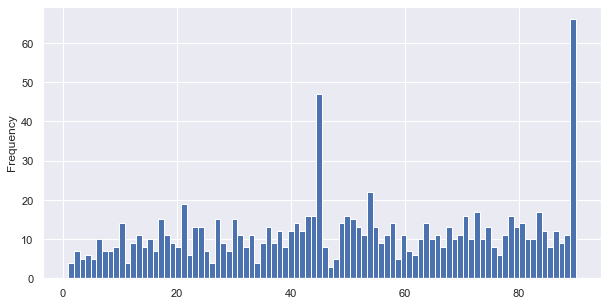

In [5]:
goals_df["Rounded_Time"].plot.hist(bins=90, figsize=(10,5))

### Kolmogorov-Smirnov test

A test for continuous distributions based on the empirical distribution function (EDF)

#### Reference

https://www.statisticshowto.com/kolmogorov-smirnov-test/

In [6]:
from scipy import stats

# set random seed as we are drawing random samples from continuous uniform distribution
np.random.seed(0)
test_stat, pvalue = stats.kstest(rvs=goals_df["Rounded_Time"], cdf=stats.uniform(0,90).rvs(size=len(goals_df)))

print(f"Test statistics: {test_stat:.3f}")
print(f"P value: {pvalue:.3f}")
if pvalue < 0.05:
    print("The null hypothesis is rejected. The distribution of goal scoring time is not uniform.")
else:
    print("The null hypothesis is not rejected. The distribution of goal scoring time is uniform.")

Test statistics: 0.117
P value: 0.000
The null hypothesis is rejected. The distribution of goal scoring time is not uniform.


### Chi-square test

A test for continuous and discrete distributions based on the observed and expected frequencies.

Note:
This test is invalid when the observed or expected frequencies in each category are too small. A typical rule is that all of the observed and expected frequencies should be at least 5.

#### Reference

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

### Categorizing stoppage time

Another way of dealing with stoppage time is to bin the goal scoring time into 5-minute interval and treat the intervals as discrete distribution.

This way, we can treat the stoppage time as an interval itself.

In [7]:
def create_bins(s:pd.Series):
    s_new = s.replace({"45\+[0-9]":"first_half_stoppage", "90\+[0-9]":"second_half_stoppage"}, regex=True)
    is_stoppage = s_new.isin(["first_half_stoppage", "second_half_stoppage"])

    # bin the non stoppage time into 5-minute interval 
    non_stoppage = s_new[~is_stoppage].astype(int)
    interval_index = pd.interval_range(start=0, end=90, freq=5)
    non_stoppage_interval = pd.cut(non_stoppage, bins=interval_index).astype("str")
    
    # append with stoppage to return series of same length
    stoppage = s_new[is_stoppage]
    full_interval = non_stoppage_interval.append(stoppage, verify_integrity=True)
    assert len(s) == len(full_interval) 
    
    return full_interval

goals_df["Time Interval"] = create_bins(goals_df["Time"])

In [8]:
goals_df["Time Interval"].value_counts()

(50, 55]                74
(40, 45]                72
(70, 75]                66
(80, 85]                63
(20, 25]                58
(85, 90]                55
(75, 80]                54
(35, 40]                54
(65, 70]                53
second_half_stoppage    51
(25, 30]                50
(55, 60]                50
(15, 20]                50
(60, 65]                47
(45, 50]                46
(5, 10]                 46
(30, 35]                43
(10, 15]                42
first_half_stoppage     33
(0, 5]                  27
Name: Time Interval, dtype: int64

In [9]:
test_stat, pvalue = stats.chisquare(f_obs=goals_df["Time Interval"].value_counts())
print(f"Test statistics: {test_stat:.3f}")
print(f"P value: {pvalue:.3f}")
if pvalue < 0.05:
    print("The null hypothesis is rejected. The distribution of goal scoring time is not uniform.")
else:
    print("The null hypothesis is not rejected. The distribution of goal scoring time is uniform.")

Test statistics: 48.940
P value: 0.000
The null hypothesis is rejected. The distribution of goal scoring time is not uniform.


### Conclusion

Both tests indicate that the goals scoring time does not follow a uniform distribution. This suggests that there is a specific interval where there is a higher probability of observing a goal.

From the empirical data, 

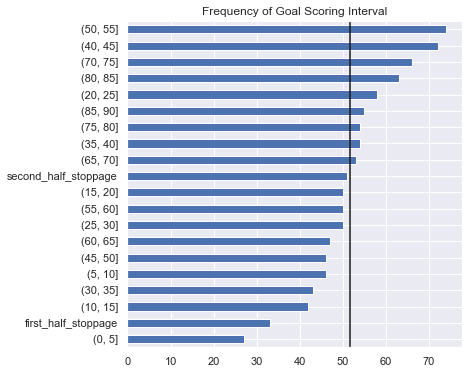

In [10]:
interval_counts = goals_df["Time Interval"].value_counts(ascending=True)

ax = interval_counts.plot.barh(figsize=(6,6), title="Frequency of Goal Scoring Interval")
# indicate the mean
ax.axvline(x=interval_counts.mean(), color='k', linestyle='-')